# Visulaizing intermediate layers of a Neural Network

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.utils.data as data_utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load dataset - Train data

In [2]:
file_train = 'Data/train-images.idx3-ubyte'
arr_train = idx2numpy.convert_from_file(file_train)

In [3]:
file_train_lbl = "Data/train-labels.idx1-ubyte"
arr_train_lbl = idx2numpy.convert_from_file(file_train_lbl)

In [4]:
arr_train.shape

(60000, 28, 28)

In [5]:
# Normalizing the data  between 0 and 1
train_data_arr = arr_train.astype('float')/255.0

In [6]:
# Reshaping it to match the input shape
tr_shape = train_data_arr.shape
train_data_arr = train_data_arr.reshape(tr_shape[0],1,tr_shape[1], tr_shape[2])

In [7]:
train_data_arr = torch.from_numpy(train_data_arr)
arr_train_lbl = torch.from_numpy(arr_train_lbl)

In [8]:
train = data_utils.TensorDataset(train_data_arr, arr_train_lbl)

In [9]:
# Making a DataLoader from train data
train_loader = DataLoader(train, batch_size=120, shuffle=True)

In [10]:
# Fetching the step size
num_train_steps = len(train_loader.dataset)//120

## Task- 1

Building a CNN model 

### Conv Network

In [11]:
# Creating a Convnet model
class Net(nn.Module):
    def __init__(self):
        # Initialize the parent class
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.relu1 = nn.ReLU()
        self.argmaxes = []
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5,5), stride=(1,1))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        
        self.linear1 = nn.Linear(16*5*5, 120)
        self.relu3 = nn.ReLU()
        
        self.linear2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        
        self.linear3 = nn.Linear(84, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x, argmax1 = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x, argmax2 = self.maxpool2(x)
        
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = self.relu3(x)
        
        x = self.linear2(x)
        x = self.relu4(x)
        
        x = self.linear3(x)
        output = self.logsoftmax(x)
        self.argmaxes = [argmax1, argmax2]
        return output

In [12]:
# Funtion for forward hook to get the outputs of pool layer
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output[0].detach()
    return hook

In [13]:
print('Model Started:')
torch_model = Net()
#torch_model.maxpool2.register_forward_hook(get_activation('maxpool2'))
# Using NLLoss with Log Soft Max gives us categorical cross entropy loss
optimizer = Adam(torch_model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()
# To retain loss values
history = {'train_loss':[], 'train_accuracy':[]}

Model Started:


In [14]:
# Training the model with 25 epochs
for epoch in range(25):
    torch_model.train()
    
    trainLoss = 0
    trainAcc = 0
    
    for (arr,label) in train_loader:
        optimizer.zero_grad()
        y_pred = torch_model(arr.float())
        loss = loss_func(y_pred, label.long())
        
        loss.backward()
        optimizer.step()
        
        trainLoss += loss
        trainAcc+=(y_pred.argmax(1) ==label).type(torch.float).sum().item()

    avgTrainLoss = trainLoss / num_train_steps
    trainAcc = trainAcc / len(train_loader.dataset)

    history["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    history["train_accuracy"].append(trainAcc)

In [15]:
# The train loss and accuracy values
history

{'train_loss': [array(1.1679368, dtype=float32),
  array(0.3291444, dtype=float32),
  array(0.23839165, dtype=float32),
  array(0.19132331, dtype=float32),
  array(0.15872599, dtype=float32),
  array(0.1366072, dtype=float32),
  array(0.12070192, dtype=float32),
  array(0.1069392, dtype=float32),
  array(0.0976535, dtype=float32),
  array(0.089297, dtype=float32),
  array(0.08375711, dtype=float32),
  array(0.07810402, dtype=float32),
  array(0.07386982, dtype=float32),
  array(0.0695911, dtype=float32),
  array(0.06640249, dtype=float32),
  array(0.06277695, dtype=float32),
  array(0.05997819, dtype=float32),
  array(0.05775074, dtype=float32),
  array(0.05489318, dtype=float32),
  array(0.05253713, dtype=float32),
  array(0.05013769, dtype=float32),
  array(0.04821813, dtype=float32),
  array(0.04683891, dtype=float32),
  array(0.04453014, dtype=float32),
  array(0.04322854, dtype=float32)],
 'train_accuracy': [0.68785,
  0.9038166666666667,
  0.9289166666666666,
  0.9424833333333333

### Load data- Test data

In [16]:
file_test = 'Data/t10k-images.idx3-ubyte'
arr_test = idx2numpy.convert_from_file(file_test)

In [17]:
file_test_lbl = "Data/t10k-labels.idx1-ubyte"
arr_test_lbl = idx2numpy.convert_from_file(file_test_lbl)

In [18]:
arr_test.shape

(10000, 28, 28)

In [19]:
test_data_arr = arr_test.astype('float')/255.0

In [20]:
te_shape = test_data_arr.shape
test_data_arr = test_data_arr.reshape(te_shape[0],1,te_shape[1], te_shape[2])

In [21]:
test_data_arr = torch.from_numpy(test_data_arr)
arr_test_lbl = torch.from_numpy(arr_test_lbl)

In [22]:
test = data_utils.TensorDataset(test_data_arr, arr_test_lbl)

In [23]:
test_loader = DataLoader(test, batch_size=120, shuffle=False)

In [24]:
# Testing on data
with torch.no_grad():
    test_acc = 0
    torch_model.eval()
    
    y_preds = []
    
    for (arr, y) in test_loader:
        y_pred = torch_model(arr.float())
        
        y_preds.extend(y_pred.argmax(axis=1).cpu().numpy())
        test_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()
        
    test_acc = test_acc/len(test_loader.dataset)
    print('Accuracy on Test set-', test_acc*100)

Accuracy on Test set- 98.53


In [236]:
arr_test_lbl[9]

tensor(9, dtype=torch.uint8)

In [237]:
# Fetch on test image for applying deconv
test_image1 = test_data_arr[9].reshape(1,1,te_shape[1], te_shape[2])

In [238]:
torch_model.maxpool2.register_forward_hook(get_activation('maxpool2'))

In [239]:
# Get just one output of the test image
with torch.no_grad():
    
    output = torch_model(test_image1.float())
    

In [240]:
# Correctly classified
output.argmax(axis=1)

tensor([9])

In [241]:
# QA: Looking at the size of output of maxpool2
activation['maxpool2'].shape

torch.Size([1, 16, 5, 5])

### Observation:
-> Got an accuracy of 98.39 on test data

## Task- 2

Building a Deconv Neural network to visualize outputs of each layer

### Deconvnet

In [242]:
unpool_argmax = torch_model.argmaxes

In [243]:
# Fetch and Transpose con weights
conv_weights = []
torch_model_children = list(torch_model.children())

conv1_w = torch_model_children[0].weight
conv_weights.append(conv1_w.permute(1,0,3,2))

conv2_w = torch_model_children[3].weight
conv_weights.append(conv2_w.permute(1,0,3,2))

In [244]:
(conv_weights[0].shape, conv_weights[1].shape)

(torch.Size([1, 6, 5, 5]), torch.Size([6, 16, 5, 5]))

In [245]:
class deconvnet(nn.Module):
    def __init__(self, unpool_argmax, conv_weights):
        super(deconvnet, self).__init__()
        self.conv_weights = conv_weights
        self.unpool_argmax = unpool_argmax
        
        self.unpool1 = nn.MaxUnpool2d(kernel_size=(2,2), stride=(2,2))

        self.relu1 = nn.ReLU()
        # Based on the required output and input, we also have the kernel size so padding of 4 and stride of 1 fits in well
        self.deconv1 = nn.Conv2d(16,6, kernel_size=(5,5), stride=(1,1), padding=(4,4))
        self.deconv1.weight = torch.nn.Parameter(self.conv_weights[1], requires_grad=False)
        self.unpool2 = nn.MaxUnpool2d(kernel_size=(2,2), stride=(2,2))
        self.relu2 = nn.ReLU()
        self.deconv2 = nn.Conv2d(6,1, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.deconv2.weight = torch.nn.Parameter(self.conv_weights[0], requires_grad=False)
        
    def forward(self, x):
        x = self.unpool1(x, self.unpool_argmax[1])
        x = self.relu1(x)
        x = self.deconv1(x)
        
        x = self.unpool2(x, self.unpool_argmax[0])
        x = self.relu2(x)
        x = self.deconv2(x)
        
        return x

In [246]:
model_deconv = deconvnet(unpool_argmax=unpool_argmax, conv_weights=conv_weights)

In [247]:
# Get just one output of a test image
with torch.no_grad():
    output = model_deconv(activation['maxpool2'])  

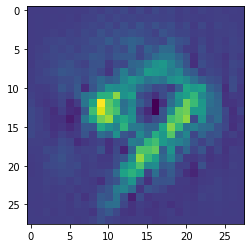

In [248]:
# Image generated by deconv
plt.imshow(output[0][0])

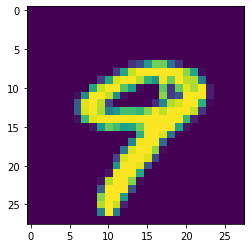

In [249]:
# Original test image
plt.imshow(test_image1[0][0])

## Task 3

Feature maps

In [250]:
# Fetching the activation feature map by zeroing everything except the one target feature
activ_imgs = []
for i in range(6):
    zero_conv_w1 = torch.zeros_like(conv1_w)
    zero_conv_w1[i] = conv1_w[i]
    conv_weights_changed = [zero_conv_w1.permute(1,0,3,2), conv2_w.permute(1,0,3,2)]
    model_temp = deconvnet(unpool_argmax=unpool_argmax, conv_weights=conv_weights_changed)
    
    with torch.no_grad():   
        output = model_temp(activation['maxpool2'])
    activ_imgs.append(output[0][0])

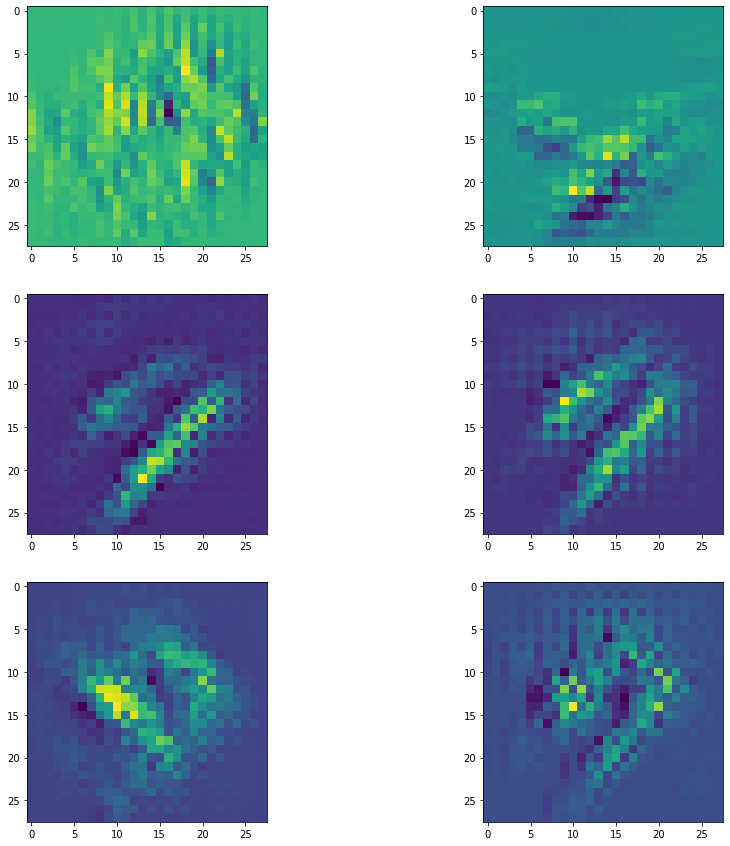

In [251]:
# Plotting the feature map
figure, axis = plt.subplots(3, 2, figsize =(15,15))

k = 0
for i in range(3):
    for j in range(2):
        axis[i,j].imshow(activ_imgs[k], )
        k+=1
plt.show()

In [252]:
# Feature map of the second layer
activ_imgs = []
for i in range(16):
    zero_conv_w2 = torch.zeros_like(conv2_w)
    zero_conv_w2[i] = conv2_w[i]
    conv_weights_changed = [conv1_w.permute(1,0,3,2), zero_conv_w2.permute(1,0,3,2)]
    model_temp = deconvnet(unpool_argmax=unpool_argmax, conv_weights=conv_weights_changed)
    
    with torch.no_grad():
        output = model_temp(activation['maxpool2'])
    activ_imgs.append(output[0][0])

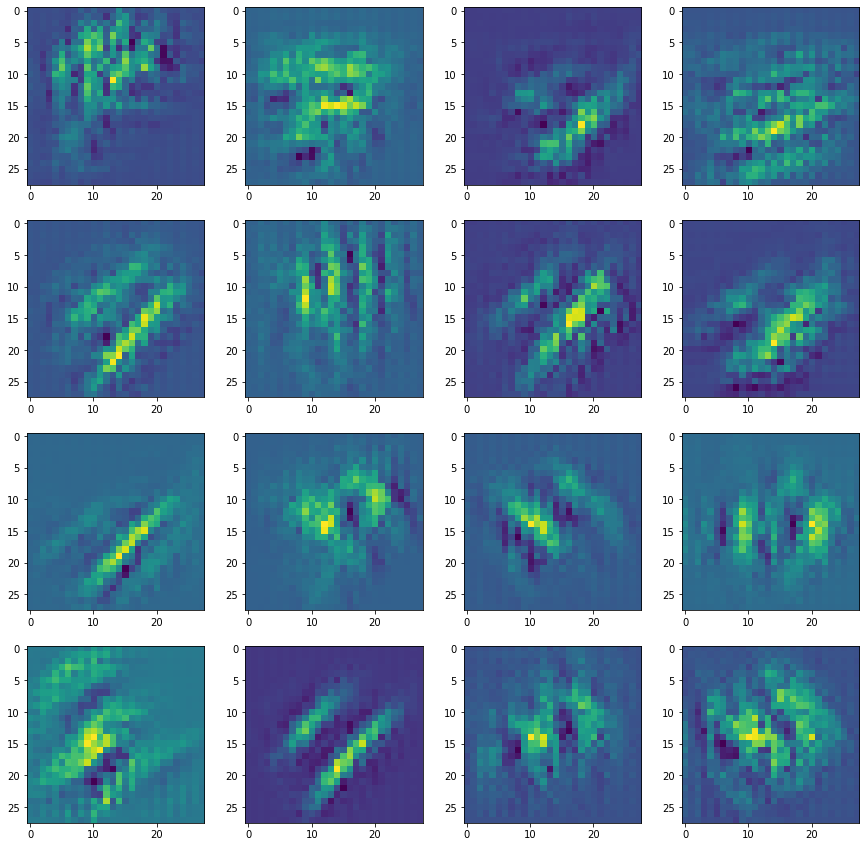

In [253]:
figure, axis = plt.subplots(4, 4, figsize =(15,15))

k = 0
for i in range(4):
    for j in range(4):
        axis[i,j].imshow(activ_imgs[k])
        k+=1
plt.show()

### The End